# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


- 사전 준비

In [8]:
# google colab전용
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# Mecab 설치를 위한 환경구성

import os
# install konlpy, jdk, JPype
!pip install konlpy
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!pip3 install JPype1-py3

# install mecab-ko
os.chdir('/tmp/')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
!tar zxfv mecab-0.996-ko-0.9.2.tar.gz
os.chdir('/tmp/mecab-0.996-ko-0.9.2')
!./configure
!make
!make check
!make install

# install mecab-ko-dic
!apt-get install automake
os.chdir('/tmp')
!curl -LO https://bitbucket.org/eunjeon/mecab-ko-dic/downloads/mecab-ko-dic-2.1.1-20180720.tar.gz
!tar -zxvf mecab-ko-dic-2.1.1-20180720.tar.gz
os.chdir('/tmp/mecab-ko-dic-2.1.1-20180720')
!./autogen.sh
!./configure
!make
!make install

# install mecab-python
os.chdir('/content')
!git clone https://bitbucket.org/eunjeon/mecab-python-0.996.git
os.chdir('/content/mecab-python-0.996')
!python3 setup.py build
!python3 setup.py install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 66.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 2.1 MB/s 
  Created wheel for JPype1-py3: filename=JPype1_py3-0.5.5.4-cp37-cp37m-linux_x86_64.whl size=2686292 sha256=dc99094a3488d554aabb4d8fee43a96d3774db31cec7531ac9ad3a0ba3c4421d
  Stored in directory: /root/.cache/pip/wheels/e7/d1/09/f55dca0203b0691945bdf0f63d486a0b4d4e5ec4bd78a2502e
Successfully built JPype1-py3
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 1381k  100 1381k    0     0   506k      0  0:00:02  0:00:02 --:--:-- 1461k
meca

### 라이브러리 버전을 확인해 봅니다


In [10]:
import tensorflow as tf
from keras import optimizers
import keras

import os
import pandas as pd
import numpy as np

import konlpy
import gensim
from gensim.models.keyedvectors import Word2VecKeyedVectors

import matplotlib.pyplot as plt

from konlpy.tag import Mecab
from collections import Counter

from sklearn.model_selection import train_test_split

print(konlpy.__version__)
print(gensim.__version__)

0.6.0
3.6.0


### 함수 정의

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]


# 모델 성과를 그려주는 함수
def plot_model(history):
  history_dict = history.history
  print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)

  # "bo"는 "파란색 점"입니다
  plt.plot(epochs, loss, 'bo', label='Training loss')
  # b는 "파란 실선"입니다
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

  plt.clf()   # 그림을 초기화합니다
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

# 모델 평가 함수
def eval_model(model):
  results = model.evaluate(X_test, y_test, verbose=2)
  print(results)


print('ok')

ok


## 1) 데이터 준비와 확인


In [12]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2) 데이터로더 구성


- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [13]:
# 토큰화 

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','에게','와','한','하다',
             '으면서','었','았','다','겠','수','있','.',',','랑','하','을','으면','에서','으면',"'",'으려는','하',
            '다','처럼','니까','네요','했','는데','에서','로','일까','고','아요','네','에요','-@','@-','죠',
             '/','-',':','였','냐','서','라고','니','면서','해서','임','입니다','라는','다는','시','님','어서',
             '인데','그리고,','는지','부터','요','며','세요','은데','다니','인지','데','여','는다','란','된다',
             '해요','러','동안','%','돼','에겐','구요','됬','이란','으니','하고','지','어','아','기','던','해','습니다',
             '함','라','1','2','3','다고','합니다','엔','이나','라면','한테','려고','해야','군요','네여','>']

def load_data(train_data, test_data, num_words=12000):
    train_data.drop_duplicates(subset=['document'], inplace=True)  # 중복제거
    train_data = train_data.dropna(how = 'any')                    # 결측치 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence)
        # print(temp_X)                          # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        # print(temp_X)
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence)                          # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(12000-4)
    vocab = ['', '', '',''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}  # 사전 만들기
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)
print('ok')

ok


In [14]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다

del word_to_index['']
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3
# word_to_index

- index_to_word 구성

In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word[0]
len(index_to_word)

12000

## 3) 모델 구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [16]:
# 데이터 셋 문장길이 분포

total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 적절한 최대 문장길이 지정 : (평균 + 3*표준편차)  
max_tokens = np.mean(num_tokens) + 3 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {:.1f}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens)*100 / len(num_tokens)))

문장길이 평균 :  11.633872396193285
문장길이 최대 :  115
문장길이 표준편차 :  9.26968001491659
pad_sequences maxlen :  39
전체 문장의 97.3%가 maxlen 설정값 이내에 포함됩니다. 


In [17]:
# keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

# pre가 유리하다. : 왜냐하면 뒷 부분이 중요하기 때문.(앞에 <PAD>를 삽입해야 함.)

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)



(146182, 39)


- validation 구분

In [18]:
# # validation set 49157 건 분리 : test 셋과 맞춰보기.
# x_val = X_train[:49157]   
# y_val = y_train[:49157]

# # validation set을 제외한 나머지 97025 건
# partial_x_train = X_train[49157:]
# partial_y_train = y_train[49157:]


# # print(X_test.shape)
# # print(X_train.shape)

# 훈련 데이터와 평가 데이터를 분리

partial_x_train, x_val, partial_y_train, y_val = train_test_split(X_train,
                                                                  y_train,
                                                                  test_size=49157/146182,
                                                                  random_state=15)

print(partial_x_train.shape)
print(partial_y_train.shape)

(97025, 39)
(97025,)


## ********* RNN *********

### 4) 모델 구성

모델은 3가지 이상 다양하게 구성하여 실험해 보세요.



In [19]:
# RNN

vocab_size = 12000       # 어휘 사전의 크기입니다
word_vector_dim = 16      # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_rnn.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_rnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          192000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 192,881
Trainable params: 192,881
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시


In [20]:
# 모델 학습 (RNN)

opt_adam_rnn = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_rnn.compile(optimizer= opt_adam_rnn,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20                              # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_rnn = model_rnn.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=2)

Epoch 1/20
190/190 - 10s - loss: 0.6902 - accuracy: 0.5359 - val_loss: 0.6849 - val_accuracy: 0.5603 - 10s/epoch - 50ms/step
Epoch 2/20
190/190 - 1s - loss: 0.6722 - accuracy: 0.5833 - val_loss: 0.6522 - val_accuracy: 0.6038 - 1s/epoch - 6ms/step
Epoch 3/20
190/190 - 1s - loss: 0.6167 - accuracy: 0.6632 - val_loss: 0.5830 - val_accuracy: 0.7175 - 1s/epoch - 6ms/step
Epoch 4/20
190/190 - 1s - loss: 0.5605 - accuracy: 0.7586 - val_loss: 0.5467 - val_accuracy: 0.7652 - 1s/epoch - 6ms/step
Epoch 5/20
190/190 - 1s - loss: 0.5297 - accuracy: 0.7968 - val_loss: 0.5250 - val_accuracy: 0.7941 - 1s/epoch - 6ms/step
Epoch 6/20
190/190 - 1s - loss: 0.5079 - accuracy: 0.8186 - val_loss: 0.5079 - val_accuracy: 0.8090 - 1s/epoch - 6ms/step
Epoch 7/20
190/190 - 1s - loss: 0.4893 - accuracy: 0.8321 - val_loss: 0.4936 - val_accuracy: 0.8253 - 1s/epoch - 6ms/step
Epoch 8/20
190/190 - 1s - loss: 0.4729 - accuracy: 0.8429 - val_loss: 0.4806 - val_accuracy: 0.8318 - 1s/epoch - 6ms/step
Epoch 9/20
190/190 - 

### 6) Loss, Accuracy 그래프 시각화


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


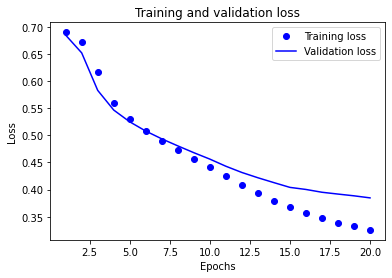

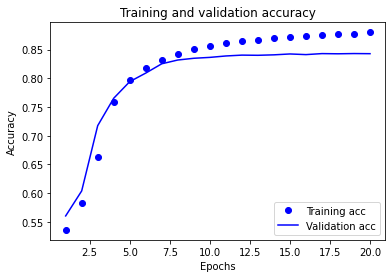

1537/1537 - 3s - loss: 0.3916 - accuracy: 0.8387 - 3s/epoch - 2ms/step
[0.3915923535823822, 0.8387208580970764]


In [21]:
# 모델 성과 그려보기
plot_model(history_rnn)

# 모델 평가
eval_model(model_rnn)

## ********* CNN *********

### 4) 모델 구성

In [22]:
# CNN

model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 5, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          192000    
                                                                 
 conv1d (Conv1D)             (None, None, 16)          1296      
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 16)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1296      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 8)                

### 5) 모델 훈련 개시


In [23]:
# 모델 학습 (CNN)
opt_adam_cnn = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_cnn.compile(optimizer=opt_adam_cnn,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30                               # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=2
                        )

Epoch 1/30
190/190 - 6s - loss: 0.6930 - accuracy: 0.5031 - val_loss: 0.6928 - val_accuracy: 0.5042 - 6s/epoch - 31ms/step
Epoch 2/30
190/190 - 1s - loss: 0.6922 - accuracy: 0.5574 - val_loss: 0.6913 - val_accuracy: 0.6167 - 818ms/epoch - 4ms/step
Epoch 3/30
190/190 - 1s - loss: 0.6891 - accuracy: 0.6559 - val_loss: 0.6861 - val_accuracy: 0.6888 - 818ms/epoch - 4ms/step
Epoch 4/30
190/190 - 1s - loss: 0.6788 - accuracy: 0.7132 - val_loss: 0.6695 - val_accuracy: 0.7232 - 816ms/epoch - 4ms/step
Epoch 5/30
190/190 - 1s - loss: 0.6524 - accuracy: 0.7487 - val_loss: 0.6328 - val_accuracy: 0.7587 - 825ms/epoch - 4ms/step
Epoch 6/30
190/190 - 1s - loss: 0.6049 - accuracy: 0.7768 - val_loss: 0.5785 - val_accuracy: 0.7803 - 828ms/epoch - 4ms/step
Epoch 7/30
190/190 - 1s - loss: 0.5463 - accuracy: 0.7954 - val_loss: 0.5219 - val_accuracy: 0.7919 - 808ms/epoch - 4ms/step
Epoch 8/30
190/190 - 1s - loss: 0.4918 - accuracy: 0.8075 - val_loss: 0.4762 - val_accuracy: 0.8026 - 822ms/epoch - 4ms/step
Ep

### 6) Loss, Accuracy 그래프 시각화


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


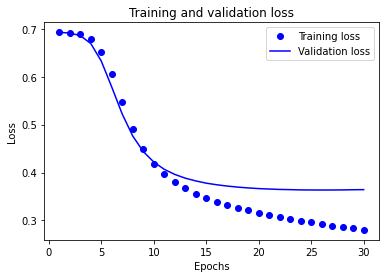

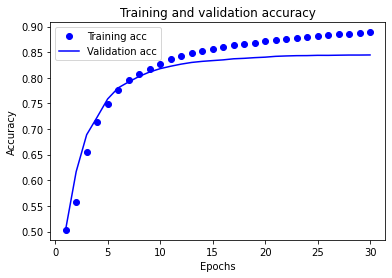

1537/1537 - 3s - loss: 0.3720 - accuracy: 0.8406 - 3s/epoch - 2ms/step
[0.37195923924446106, 0.8405516743659973]


In [24]:
# 모델 성과 그려보기
plot_model(history_cnn)

# 모델 평가
eval_model(model_cnn)

## ********* GMP *********
GlobalMaxPooling1D 만 사용

### 4) 모델 구성

In [25]:
# GlobalMaxPooling1D

model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_gmp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 16)          192000    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 16)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 192,145
Trainable params: 192,145
Non-trainable params: 0
_________________________________________________________________


### 5) 모델 훈련 개시


In [26]:
# 모델 학습 (GlobalMaxPooling1D)
opt_adam_gmp = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model_gmp.compile(optimizer=opt_adam_gmp,
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=30                                     # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_gmp = model_gmp.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=2)

Epoch 1/30
190/190 - 1s - loss: 0.6915 - accuracy: 0.5501 - val_loss: 0.6888 - val_accuracy: 0.6330 - 1s/epoch - 6ms/step
Epoch 2/30
190/190 - 1s - loss: 0.6838 - accuracy: 0.6728 - val_loss: 0.6785 - val_accuracy: 0.7023 - 660ms/epoch - 3ms/step
Epoch 3/30
190/190 - 1s - loss: 0.6712 - accuracy: 0.7259 - val_loss: 0.6640 - val_accuracy: 0.7333 - 657ms/epoch - 3ms/step
Epoch 4/30
190/190 - 1s - loss: 0.6535 - accuracy: 0.7527 - val_loss: 0.6442 - val_accuracy: 0.7551 - 665ms/epoch - 3ms/step
Epoch 5/30
190/190 - 1s - loss: 0.6306 - accuracy: 0.7715 - val_loss: 0.6193 - val_accuracy: 0.7717 - 656ms/epoch - 3ms/step
Epoch 6/30
190/190 - 1s - loss: 0.6028 - accuracy: 0.7901 - val_loss: 0.5913 - val_accuracy: 0.7848 - 650ms/epoch - 3ms/step
Epoch 7/30
190/190 - 1s - loss: 0.5727 - accuracy: 0.8026 - val_loss: 0.5617 - val_accuracy: 0.7956 - 658ms/epoch - 3ms/step
Epoch 8/30
190/190 - 1s - loss: 0.5417 - accuracy: 0.8124 - val_loss: 0.5328 - val_accuracy: 0.8033 - 658ms/epoch - 3ms/step
Epo

### 6) Loss, Accuracy 그래프 시각화


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


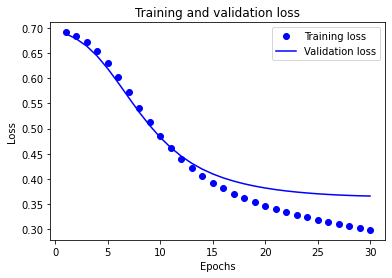

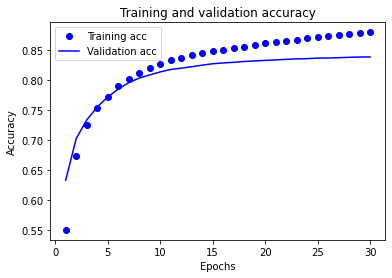

1537/1537 - 2s - loss: 0.3700 - accuracy: 0.8372 - 2s/epoch - 1ms/step
[0.3699796795845032, 0.8372154235839844]


In [27]:
# 모델 성과 그려보기
plot_model(history_gmp)

# 모델 평가
eval_model(model_gmp)

## 7) 학습된 Embedding 레이어 분석


- RNN

In [28]:
embedding_layer_rnn = model_rnn.layers[0]
weights = embedding_layer_rnn.get_weights()[0]
print(weights.shape)                           # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/word2vec_rnn.txt'
# word2vec_file_path = '~/aiffel/sentiment_classification/data/word2vec_rnn.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_rnn.get_weights()[0]
for i in range(3,weights.shape[0]):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector    

word_vectors.similar_by_word("사랑")

(12000, 16)


[('여신', 0.9583055377006531),
 ('보이스', 0.9572445154190063),
 ('최강', 0.9349989295005798),
 ('힛', 0.9326374530792236),
 ('끊이', 0.9323757886886597),
 ('평안', 0.9321808218955994),
 ('레전드', 0.9316595196723938),
 ('잊', 0.9314407706260681),
 ('유쾌', 0.9307713508605957),
 ('쩔', 0.929975688457489)]

- CNN

In [29]:
embedding_layer_cnn = model_cnn.layers[0]
weights = embedding_layer_cnn.get_weights()[0]
print(weights.shape)                           # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/word2vec_cnn.txt'
# word2vec_file_path = '~/aiffel/sentiment_classification/data/word2vec_rnn.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_cnn.get_weights()[0]
for i in range(3,weights.shape[0]):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector    

word_vectors.similar_by_word("사랑")

(12000, 16)


[('최소', 0.8787960410118103),
 ('내게는', 0.8554866313934326),
 ('흡입', 0.8418062925338745),
 ('제인', 0.8323974609375),
 ('이제서야', 0.8235266804695129),
 ('괜찬', 0.8186856508255005),
 ('은유', 0.8157346248626709),
 ('재미있', 0.8062759637832642),
 ('짠', 0.8058568239212036),
 ('만점', 0.8057636022567749)]

- GMP

In [30]:
embedding_layer_gmp = model_gmp.layers[0]
weights = embedding_layer_gmp.get_weights()[0]
print(weights.shape)                           # shape: (vocab_size, embedding_dim)

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/word2vec_.gmptxt'
# word2vec_file_path = '~/aiffel/sentiment_classification/data/word2vec_rnn.txt'

f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 3개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_gmp.get_weights()[0]
for i in range(3,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()


word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector    # 무려 300dim의 워드 벡터입니다.

word_vectors.similar_by_word("사랑")

(12000, 16)


[('다시', 0.964191734790802),
 ('관한', 0.9517941474914551),
 ('정준용', 0.9490139484405518),
 ('순수', 0.948881983757019),
 ('이색', 0.9412696361541748),
 ('탁월', 0.9310846328735352),
 ('놀라웠', 0.9260897636413574),
 ('보여준다', 0.9238660931587219),
 ('연대기', 0.9157897233963013),
 ('읊', 0.9065783619880676)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 
- 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 
- 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.  
https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models  
https://radimrehurek.com/gensim/models/keyedvectors.html

In [31]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path = '/content/drive/MyDrive/Colab Notebooks/Exploration/sentiment_classification/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [32]:
word_vectors.wv.most_similar("사랑")

[('이별', 0.7626415491104126),
 ('행복', 0.7550067901611328),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588401794434),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

In [33]:
vocab_size = 12000
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [34]:
from tensorflow.keras.initializers import Constant

# 모델 구성
# # CNN
# model_ko = tf.keras.Sequential()
# model_ko.add(tf.keras.layers.Embedding(vocab_size, 
#                                        word_vector_dim, 
#                                        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                        input_length=maxlen, 
#                                        trainable=True))   # trainable을 True로 주면 Fine-tuning

# # model_ko.add(tf.keras.layers.Dropout(rate=0.3))

# model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_ko.add(tf.keras.layers.MaxPooling1D(5))

# # model_ko.add(tf.keras.layers.Dropout(rate=0.3))

# model_ko.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
# model_ko.add(tf.keras.layers.GlobalMaxPooling1D())
# model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
# model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

# model_ko.summary()


# # GMP

# model_ko = tf.keras.Sequential()
# model_ko.add(tf.keras.layers.Embedding(vocab_size, 
#                                        word_vector_dim, 
#                                        embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
#                                        input_length=maxlen, 
#                                        trainable=True))   # trainable을 True로 주면 Fine-tuning
# model_ko.add(tf.keras.layers.GlobalMaxPooling1D())
# model_ko.add(tf.keras.layers.Dense(8, activation='relu'))
# model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

# model_ko.summary()

# RNN

model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size, 
                                       word_vector_dim, 
                                       embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                       input_length=maxlen, 
                                       trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_ko.add(tf.keras.layers.Dense(16, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid'))    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_ko.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 39, 100)           1200000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_6 (Dense)             (None, 16)                2064      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,319,329
Trainable params: 1,319,329
Non-trainable params: 0
_________________________________________________________________


In [35]:
# 학습의 진행
opt_adam_ko = tf.keras.optimizers.RMSprop(learning_rate=0.0000001, 
                                          epsilon=True, 
                                          rho = 0.9,
                                          decay=0.0
                                          )

model_ko.compile(optimizer = 'rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
              
epochs=15                                        # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_ko = model_ko.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=2)

Epoch 1/15
190/190 - 4s - loss: 0.4964 - accuracy: 0.7548 - val_loss: 0.4117 - val_accuracy: 0.8111 - 4s/epoch - 21ms/step
Epoch 2/15
190/190 - 2s - loss: 0.3873 - accuracy: 0.8248 - val_loss: 0.4032 - val_accuracy: 0.8140 - 2s/epoch - 10ms/step
Epoch 3/15
190/190 - 2s - loss: 0.3388 - accuracy: 0.8519 - val_loss: 0.3768 - val_accuracy: 0.8290 - 2s/epoch - 10ms/step
Epoch 4/15
190/190 - 2s - loss: 0.3063 - accuracy: 0.8689 - val_loss: 0.3382 - val_accuracy: 0.8510 - 2s/epoch - 10ms/step
Epoch 5/15
190/190 - 2s - loss: 0.2790 - accuracy: 0.8815 - val_loss: 0.3376 - val_accuracy: 0.8538 - 2s/epoch - 10ms/step
Epoch 6/15
190/190 - 2s - loss: 0.2546 - accuracy: 0.8943 - val_loss: 0.3361 - val_accuracy: 0.8538 - 2s/epoch - 10ms/step
Epoch 7/15
190/190 - 2s - loss: 0.2336 - accuracy: 0.9039 - val_loss: 0.3789 - val_accuracy: 0.8451 - 2s/epoch - 10ms/step
Epoch 8/15
190/190 - 2s - loss: 0.2129 - accuracy: 0.9137 - val_loss: 0.3650 - val_accuracy: 0.8500 - 2s/epoch - 10ms/step
Epoch 9/15
190/1

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


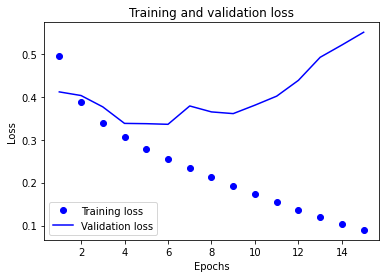

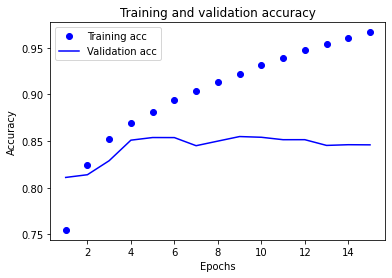

1537/1537 - 4s - loss: 0.5619 - accuracy: 0.8452 - 4s/epoch - 2ms/step
[0.5618715286254883, 0.8452102541923523]


In [36]:
# 모델 성과 그려보기
plot_model(history_ko)

# 모델 평가
eval_model(model_ko)

epochs는 6~7 정도가 좋아 보입니다. 다시 돌려보겠습니다.

In [37]:
# RNN

model_ko = tf.keras.Sequential()
model_ko.add(tf.keras.layers.Embedding(vocab_size, 
                                       word_vector_dim, 
                                       embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                       input_length=maxlen, 
                                       trainable=True))   # trainable을 True로 주면 Fine-tuning
model_ko.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_ko.add(tf.keras.layers.Dense(16, activation='relu'))
model_ko.add(tf.keras.layers.Dense(1, activation='sigmoid'))    # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_ko.summary()

# 학습의 진행
opt_adam_ko = tf.keras.optimizers.RMSprop(learning_rate=0.0000001, 
                                          epsilon=True, 
                                          rho = 0.9,
                                          decay=0.0
                                          )

model_ko.compile(optimizer = 'rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
              
epochs=7                                        # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_ko = model_ko.fit(partial_x_train,
                        partial_y_train,
                        epochs=epochs,
                        batch_size=512,
                        validation_data=(x_val, y_val),
                        verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 39, 100)           1200000   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,319,329
Trainable params: 1,319,329
Non-trainable params: 0
_________________________________________________________________
Epoch 1/7
190/190 - 4s - loss: 0.4979 - accuracy: 0.7536 - val_loss: 0.4190 - val_accuracy: 0.8077 - 4s/epoch - 21ms/step
Epoch 2/7
190/190 - 2s - loss: 0.3901 - accuracy: 0.82

In [38]:
# 모델 평가
eval_model(model_ko)

1537/1537 - 4s - loss: 0.3479 - accuracy: 0.8537 - 4s/epoch - 3ms/step
[0.34793350100517273, 0.8536729216575623]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


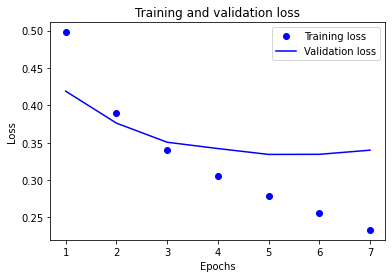

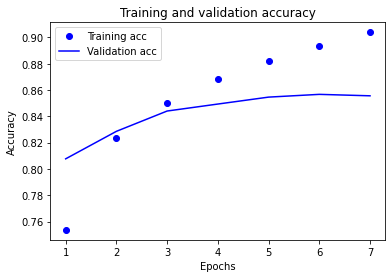

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


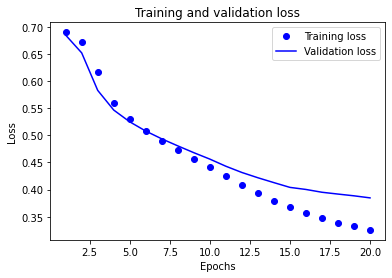

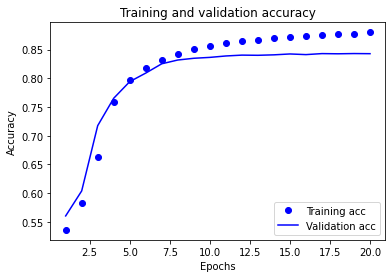

In [39]:
# 기존 단어사전과의 비교 

plot_model(history_ko)
plot_model(history_rnn)

임베딩한 사전으로 학습하는 경우 로스값이 더 낮고, 정확도가 더 높은 상태에서 학습이 시작됩니다.

최종 정확도에서는 큰 차이가 없어 보이지만, 그 과정에서 컴퓨팅 자원을 더 많이 소모하는 것으로 보입니다. 

더 좋은 단어 벡터가 있는 경우 더 빠르고 좋은 성과를 낼 수 있을 것 같습니다.
